<a href="https://colab.research.google.com/github/targoons/ML/blob/master/MLAssignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MsCA 31009 - Machine Learning and Predictive Analytics

## Assignment 4 - Random Forest and Binary Classification

**Targoon Siripanichpong**

## Import files and libraries.

In [0]:
!pip3 install xlrd

In [0]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt

import pickle

**Mount Google Drive.**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Read data.**

In [0]:
mypath = '/content/gdrive/My Drive/UChicago/Machine Learning/Data/Raw'
import os
os.listdir(mypath)

['default of credit card clients.xls',
 'train.csv.zip',
 'toxic_train.csv',
 'ProviderInfo.csv',
 'bottle.csv']

In [0]:
credit_default = pd.read_excel('/content/gdrive/My Drive/UChicago/Machine Learning/Data/Raw/default of credit card clients.xls')

## Data Exploration and Pre-Processing

In [0]:
credit_default.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [0]:
credit_default.shape

(30000, 24)

In [0]:
credit_default['SEX'] = credit_default['SEX'].astype('category')
credit_default['EDUCATION'] = credit_default['EDUCATION'].astype('category')
credit_default['MARRIAGE'] = credit_default['MARRIAGE'].astype('category')
credit_default['default payment next month'] = credit_default['default payment next month'].astype('category')

In [0]:
credit_default.dtypes

LIMIT_BAL                        int64
SEX                           category
EDUCATION                     category
MARRIAGE                      category
AGE                              int64
PAY_0                            int64
PAY_2                            int64
PAY_3                            int64
PAY_4                            int64
PAY_5                            int64
PAY_6                            int64
BILL_AMT1                        int64
BILL_AMT2                        int64
BILL_AMT3                        int64
BILL_AMT4                        int64
BILL_AMT5                        int64
BILL_AMT6                        int64
PAY_AMT1                         int64
PAY_AMT2                         int64
PAY_AMT3                         int64
PAY_AMT4                         int64
PAY_AMT5                         int64
PAY_AMT6                         int64
default payment next month    category
dtype: object

In [0]:
credit_default.describe(include= 'all')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.0,30000.0,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.0
unique,NaN,2.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
top,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
freq,NaN,18112.0,14030.0,15964.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23364.0
mean,167484.322667,NaN,NaN,NaN,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,NaN
std,129747.661567,NaN,NaN,NaN,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,NaN
min,10000.000000,NaN,NaN,NaN,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,NaN
25%,50000.000000,NaN,NaN,NaN,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,NaN
50%,140000.000000,NaN,NaN,NaN,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,NaN
75%,240000.000000,NaN,NaN,NaN,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,NaN


In [0]:
credit_default.dropna(axis=0, inplace=True)

**One Hot Encoding**

In [0]:
enc = OneHotEncoder(categorical_features = [2,3])
fit_obj = enc.fit(credit_default)
credit_default_cat = fit_obj.transform(credit_default).toarray()

In [0]:
credit_default_cat.shape

(30000, 33)

In [0]:
fit_obj.feature_indices_[:-1]

array([0, 7])

In [0]:
names_ = ['EDUCATION_'+str(i) for i in range(1,8)]+\
         ['MARRIAGE_'+str(i) for i in range(1,5)]
names_ 

['EDUCATION_1',
 'EDUCATION_2',
 'EDUCATION_3',
 'EDUCATION_4',
 'EDUCATION_5',
 'EDUCATION_6',
 'EDUCATION_7',
 'MARRIAGE_1',
 'MARRIAGE_2',
 'MARRIAGE_3',
 'MARRIAGE_4']

In [0]:
credit_default_cat_clean = pd.DataFrame(credit_default_cat[:,0:11], columns = names_)
credit_default_cat_clean.head()

,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,EDUCATION_7,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,MARRIAGE_4
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Reconcile with original data**

In [0]:
credit_default_num_clean = credit_default.drop(['EDUCATION', 'MARRIAGE'], axis=1).reset_index(drop = True).copy()

In [0]:
credit_default_clean = pd.concat([credit_default_cat_clean, credit_default_num_clean], axis = 1)

In [0]:
credit_default_clean.head()

,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,EDUCATION_7,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,689,0,0,0,0,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


**Split Train and Test data.**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(credit_default_clean.iloc[:,0:-1], credit_default_clean.iloc[:,-1], test_size = .3, random_state = 43)

In [0]:
x_train.head()

,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,EDUCATION_7,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
14120,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,54769,39137,26971,3426,2805,1487,958,539,1000,390
23150,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1,228,1374,380,0,0,229,1380,381,3880
4010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,96667,98883,79972,81642,3500,3600,3900,3000,3000,3200
19536,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,29179,30146,26371,27567,1452,2000,1500,933,2000,3000
5019,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,16879,17059,17263,17675,1577,0,757,628,700,2488


In [0]:
x_train.describe()

,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,EDUCATION_7,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000
mean,0.000476,0.350810,0.467905,0.165952,0.003952,0.009333,0.001571,0.001810,0.457762,0.529619,...,46977.176667,43198.739714,40301.590190,39034.401238,5617.556429,5.887724e+03,5266.627476,4834.623286,4880.418143,5227.275429
std,0.021817,0.477235,0.498981,0.372047,0.062745,0.096160,0.039611,0.042501,0.498225,0.499134,...,68954.078535,64420.825865,61100.629649,60039.132678,16559.119435,2.172623e+04,18231.541938,15473.292502,15144.840055,18172.413023
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-157264.000000,-65167.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2655.000000,2314.750000,1744.250000,1262.000000,1000.000000,8.150000e+02,390.000000,291.000000,259.000000,111.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,20079.000000,19052.000000,18071.500000,17012.000000,2100.000000,2.004000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,59541.500000,53963.250000,49910.000000,48961.500000,5000.000000,5.000000e+03,4500.000000,4000.000000,4088.500000,4000.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,855086.000000,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000


## Model Generation

### Random Forest Classifer - Base Model

In [0]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
y_train_predict_base = rfc.predict(x_train)
y_test_predict_base = rfc.predict(x_test)

y_train_predict_proba_base = rfc.predict_proba(x_train)[:,1]
y_test_predict_proba_base = rfc.predict_proba(x_test)[:,1]

#### Model Evaluation

In [0]:
print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.9803333333333333
0.8033333333333333


In [0]:
confusion_matrix(y_train, y_train_predict_base)

array([[16362,    21],
       [  392,  4225]])

In [0]:
confusion_matrix(y_test, y_test_predict_base)

array([[6603,  378],
       [1392,  627]])

In [0]:
print(classification_report(y_train, y_train_predict_base))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     16383
          1       1.00      0.92      0.95      4617

avg / total       0.98      0.98      0.98     21000



In [0]:
print(classification_report(y_test, y_test_predict_base))

             precision    recall  f1-score   support

          0       0.83      0.95      0.88      6981
          1       0.62      0.31      0.41      2019

avg / total       0.78      0.80      0.78      9000



In [0]:
# calculate roc_auc_score
print(roc_auc_score(y_test, y_test_predict_proba_base))

0.7215640996551951


### Random Forest Classifer - Grid Search

In [0]:
#create a dictionary of parameters 
param_grid = {'n_estimators':[500, 750, 1000],'max_features':[2, 4, 6],'random_state':[0], 'max_depth':[4,6,8]}

In [0]:
rfc = RandomForestClassifier()

# Create gridsearch object with various combinations of parameters
rfc_Grid = GridSearchCV(rfc, param_grid, cv = 5, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5)

rfc_Grid.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=4, max_features=2, n_estimators=500, random_state=0 ...
[CV] max_depth=4, max_features=2, n_estimators=500, random_state=0 ...
[CV]  max_depth=4, max_features=2, n_estimators=500, random_state=0, score=0.776192325627785, total=   5.4s
[CV] max_depth=4, max_features=2, n_estimators=500, random_state=0 ...
[CV]  max_depth=4, max_features=2, n_estimators=500, random_state=0, score=0.7824166729415433, total=   5.5s
[CV] max_depth=4, max_features=2, n_estimators=500, random_state=0 ...
[CV]  max_depth=4, max_features=2, n_estimators=500, random_state=0, score=0.7522199935133441, total=   6.1s
[CV] max_depth=4, max_features=2, n_estimators=500, random_state=0 ...
[CV]  max_depth=4, max_features=2, n_estimators=500, random_state=0, score=0.7750149814071807, total=   6.3s
[CV] max_depth=4, max_features=2, n_estimators=750, random_state=0 ...
[CV]  max_depth=4, max_features=2, n_estimators=500, random_state=0, score=0.

[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min


[CV]  max_depth=4, max_features=2, n_estimators=1000, random_state=0, score=0.7717164261042917, total=  11.9s
[CV] max_depth=4, max_features=4, n_estimators=500, random_state=0 ...
[CV]  max_depth=4, max_features=4, n_estimators=500, random_state=0, score=0.7768028050679866, total=   9.3s
[CV] max_depth=4, max_features=4, n_estimators=500, random_state=0 ...
[CV]  max_depth=4, max_features=4, n_estimators=500, random_state=0, score=0.7830930385858673, total=   9.0s
[CV] max_depth=4, max_features=4, n_estimators=500, random_state=0 ...
[CV]  max_depth=4, max_features=4, n_estimators=500, random_state=0, score=0.7531091811307742, total=   9.0s
[CV] max_depth=4, max_features=4, n_estimators=500, random_state=0 ...
[CV]  max_depth=4, max_features=4, n_estimators=500, random_state=0, score=0.7766161399693361, total=   9.1s
[CV] max_depth=4, max_features=4, n_estimators=750, random_state=0 ...
[CV]  max_depth=4, max_features=4, n_estimators=500, random_state=0, score=0.773364380894175, total

[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  8.3min


[CV]  max_depth=6, max_features=4, n_estimators=750, random_state=0, score=0.7791399944704387, total=  18.9s
[CV] max_depth=6, max_features=4, n_estimators=1000, random_state=0 ..
[CV]  max_depth=6, max_features=4, n_estimators=750, random_state=0, score=0.776661778693198, total=  18.2s
[CV] max_depth=6, max_features=4, n_estimators=1000, random_state=0 ..
[CV]  max_depth=6, max_features=4, n_estimators=1000, random_state=0, score=0.7810712072994649, total=  24.5s
[CV] max_depth=6, max_features=4, n_estimators=1000, random_state=0 ..
[CV]  max_depth=6, max_features=4, n_estimators=1000, random_state=0, score=0.7892356473757145, total=  24.3s
[CV] max_depth=6, max_features=4, n_estimators=1000, random_state=0 ..
[CV]  max_depth=6, max_features=4, n_estimators=1000, random_state=0, score=0.7549606221635345, total=  24.2s
[CV] max_depth=6, max_features=4, n_estimators=1000, random_state=0 ..
[CV]  max_depth=6, max_features=4, n_estimators=1000, random_state=0, score=0.7793099821810547, to

KeyboardInterrupt: ignored

In [0]:
rfc_Grid.best_params_

{'max_features': 2, 'n_estimators': 1000, 'random_state': 0}

In [0]:
rfc_Grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
y_train_predict_grid = rfc_Grid.best_estimator_.predict(x_train)
y_test_predict_grid = rfc_Grid.best_estimator_.predict(x_test)

y_train_predict_proba_grid = rfc_Grid.best_estimator_.predict_proba(x_train)[:,1]
y_test_predict_proba_grid = rfc_Grid.best_estimator_.predict_proba(x_test)[:,1]

**Save the best model as a Pickle object.**

In [0]:
# where do I want to store this file?
classifier_pkl_path = '/content/gdrive/My Drive/UChicago/Machine Learning/best_classifier.pkl'

# Open the file to save as pkl file
classifier_model_pkl = open(classifier_pkl_path, 'wb')
pickle.dump(rfc_Grid.best_estimator_, classifier_model_pkl)

# Close the pickle instances
classifier_model_pkl.close()

#### Model Evaluation

In [0]:
print(accuracy_score(y_train, y_train_predict_grid))
print(accuracy_score(y_test, y_test_predict_grid))

0.9994761904761905
0.8094444444444444


In [0]:
confusion_matrix(y_train, y_train_predict_grid)

array([[16379,     4],
       [    7,  4610]])

In [0]:
confusion_matrix(y_test, y_test_predict_grid)

array([[6637,  344],
       [1371,  648]])

In [0]:
print(classification_report(y_train, y_train_predict_grid))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     16383
          1       1.00      1.00      1.00      4617

avg / total       1.00      1.00      1.00     21000



In [0]:
print(classification_report(y_test, y_test_predict_grid))

             precision    recall  f1-score   support

          0       0.83      0.95      0.89      6981
          1       0.65      0.32      0.43      2019

avg / total       0.79      0.81      0.78      9000



In [0]:
# calculate roc_auc_score
print(roc_auc_score(y_train, y_train_predict_proba_grid))
print(roc_auc_score(y_test, y_test_predict_proba_grid))

0.9999992001619348
0.7659348352235201


### Model Comparison

The best parameters from the grid search are: **'max_features': 2, 'n_estimators': 1000**

The model from grid search performs better in comparison to how the base model performs, as observed from the confusion matrices and the AUC score.

## Feature Importance

In [0]:
list(zip(list(x_train.columns.values), [round(i, 5) for i in rfc_Grid.best_estimator_.feature_importances_]))

[('EDUCATION_1', 2e-05),
 ('EDUCATION_2', 0.00754),
 ('EDUCATION_3', 0.00841),
 ('EDUCATION_4', 0.00679),
 ('EDUCATION_5', 0.00036),
 ('EDUCATION_6', 0.00107),
 ('EDUCATION_7', 0.00038),
 ('MARRIAGE_1', 0.00039),
 ('MARRIAGE_2', 0.00761),
 ('MARRIAGE_3', 0.00756),
 ('MARRIAGE_4', 0.00151),
 ('LIMIT_BAL', 0.06358),
 ('SEX', 0.01196),
 ('AGE', 0.06391),
 ('PAY_0', 0.07978),
 ('PAY_2', 0.04137),
 ('PAY_3', 0.02825),
 ('PAY_4', 0.02605),
 ('PAY_5', 0.02549),
 ('PAY_6', 0.02219),
 ('BILL_AMT1', 0.05704),
 ('BILL_AMT2', 0.05354),
 ('BILL_AMT3', 0.05197),
 ('BILL_AMT4', 0.05105),
 ('BILL_AMT5', 0.05012),
 ('BILL_AMT6', 0.05026),
 ('PAY_AMT1', 0.05174),
 ('PAY_AMT2', 0.04808),
 ('PAY_AMT3', 0.04629),
 ('PAY_AMT4', 0.04448),
 ('PAY_AMT5', 0.04461),
 ('PAY_AMT6', 0.04658)]

In [0]:
label = x_train.columns.values
feature_imp = rfc_Grid.best_estimator_.feature_importances_

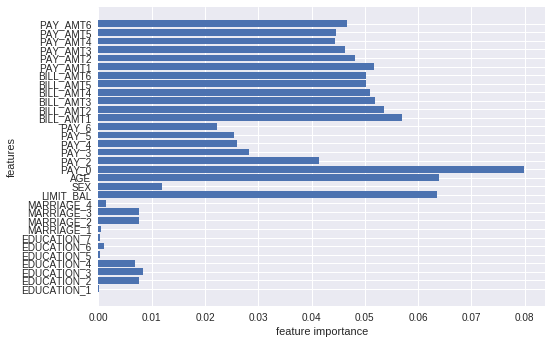

In [0]:
index = np.arange(len(label))
plt.barh(index, feature_imp)
plt.ylabel('features')
plt.xlabel('feature importance')
plt.yticks(index, label)
plt.show()

The top 5 features from this model are:

* PAY_0
* AGE
* LIMIT_BAL
* BILL_AMT1
* BILL_AMT2

In [0]:
!jupyter nbconvert --to html '/content/gdrive/My Drive/Colab Notebooks/MLAssignment4.ipynb'

[NbConvertApp] Converting notebook /content/gdrive/My Drive/Colab Notebooks/MLAssignment4.ipynb to html
[NbConvertApp] Writing 388333 bytes to /content/gdrive/My Drive/Colab Notebooks/MLAssignment4.html
